In [1]:
# 1. Clone and setup FBPINNs
!git clone https://github.com/thiae/FBPINNs.git
%cd FBPINNs
!python colab_setup.py

# 2. Navigate to poroelasticity and setup paths
%cd poroelasticity
!python setup_path.py

# 3. Validate everything works
!python simple_validation.py

Cloning into 'FBPINNs'...
remote: Enumerating objects: 770, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 770 (delta 137), reused 99 (delta 85), pack-reused 568 (from 2)
Receiving objects: 100% (770/770), 15.71 MiB | 38.22 MiB/s, done.
Resolving deltas: 100% (418/418), done.
/content/FBPINNs
FBPINNs Colab Setup
Setup method: auto

Installing dependencies...
  Detected Google Colab - using GPU JAX
  Installing jax[cuda12]>=0.4.8...
  SUCCESS: jax[cuda12]>=0.4.8 installed successfully
  Installing optax>=0.1.4...
  SUCCESS: optax>=0.1.4 installed successfully
  Installing numpy>=1.24.2...
  SUCCESS: numpy>=1.24.2 installed successfully
  Installing scipy>=1.10.1...
  SUCCESS: scipy>=1.10.1 installed successfully
  Installing matplotlib>=3.7.1...
  SUCCESS: matplotlib>=3.7.1 installed successfully
  Installing tensorboardX>=2.6...
  SUCCESS: tensorboardX>=2.6 installed successfully
  Installing ipython>=8.12.0...
  S

In [2]:
# ENVIRONMENT SETUP AND IMPROVED CLASS IMPLEMENTATION
import os
import sys
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import optax

print(" Setting up FBPINNs path...")

# Get the FBPINNs root directory (parent of current directory)
current_dir = Path.cwd()
fbpinns_root = current_dir.parent

print(f"Current directory: {current_dir}")
print(f"FBPINNs root: {fbpinns_root}")

# Add FBPINNs root to Python path (for fbpinns imports)
if str(fbpinns_root) not in sys.path:
    sys.path.insert(0, str(fbpinns_root))
    print(f" Added {fbpinns_root} to Python path")

# Add current directory to Python path (for local imports)
if str(current_dir) not in sys.path:
    sys.path.insert(0, str(current_dir))
    print(f" Added {current_dir} to Python path")

# Test fbpinns import first
try:
    import fbpinns
    print(" fbpinns module successfully imported")
except ImportError as e:
    print(f" fbpinns import failed: {e}")
    raise

# Import FBPINNs components
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

print(" All imports successful!")

 Setting up FBPINNs path...
Current directory: /content/FBPINNs/poroelasticity
FBPINNs root: /content/FBPINNs
 Added /content/FBPINNs to Python path
 Added /content/FBPINNs/poroelasticity to Python path
 fbpinns module successfully imported
 All imports successful!


In [3]:
"""
Biot‐Coupled poroelasticity with spatially heterogeneous permeability.

This module defines a JAX/FBPINN implementation of the 2D transient Biot
equations where the permeability may vary in space.  It reuses
most of the structure from the homogeneous base model (see
`base_model.py`) but modifies the flow residual to account
for a spatially varying permeability field `k(x, y)`.  Users can supply
their own permeability function when constructing the trainer; by
default a simple layered distribution is used to emulate a caprock
/ reservoir system.

Key features:

* The network takes three inputs `(x, y, t)` and outputs `(u_x, u_y, p)`.
* Hard Dirichlet boundary conditions enforce displacement fixation on
  the left and bottom boundaries and prescribe pressure on the left and
  right boundaries.  Initial conditions are satisfied by a smooth
  temporal ramp.
* The flow residual includes both `k * laplacian(p)` and the term
  `∇k·∇p` when the permeability varies smoothly.
* Physics metrics optionally compute the divergence of the Darcy flux
  `q = (k/μ) ∇p` rather than assuming constant permeability.

Note that this model remains nondimensional; users interested in
physical predictions should introduce characteristic scales as discussed
elsewhere in the report.
"""

import numpy as np
import jax
import jax.numpy as jnp
import optax
import pickle
import os
import matplotlib.pyplot as plt
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer, get_inputs, FBPINN_model_jit


class BiotCoupled2D_Heterogeneous(Problem):
    """
    2D Biot poroelasticity with transient flow and spatially varying
    permeability.

    This problem class closely follows the homogeneous version but
    introduces a permeability function `k_fun(x, y)` that may vary
    spatially.  If `k_fun` is not provided, a constant permeability is
    assumed.  Users can also provide a spatially varying Young's
    modulus `E_fun(x, y)` if desired; otherwise the mechanics remain
    homogeneous.
    """

    @staticmethod
    def default_k_fun(x, y):
        """Default permeability profile: a high perm reservoir overlain by a low perm caprock.

        The domain is `y∈[0,1]` with the caprock occupying the top
        portion (y > 0.3) and the reservoir below.  A hyperbolic
        tangent is used to smoothly transition between the two zones.

        Parameters
        ----------
        x, y : array_like
            Spatial coordinates.  Only `y` is used in this default
            implementation.

        Returns
        -------
        ndarray
            Permeability values at the given coordinates.
        """
        k_reservoir = 10.0  # high permeability in the reservoir
        k_caprock = 0.1     # low permeability in the caprock
        interface_y = 0.3
        sharpness = 20.0
        # weight ~1 in caprock, ~0 in reservoir
        w = 0.5 * (1.0 + jnp.tanh(sharpness * (y - interface_y)))
        return k_caprock * w + k_reservoir * (1.0 - w)

    @staticmethod
    def default_E_fun(x, y, E_res=5000.0, E_cap=7000.0, interface_y=0.3, sharpness=20.0):
        """Default Young's modulus: piecewise (reservoir vs caprock) with smooth transition.

        Caprock (y > 0.3, above interface) stiffer than reservoir (y < 0.3, below interface). Smooth tanh transition keeps
        autodiff stable.
        """
        w = 0.5 * (1.0 + jnp.tanh(sharpness * (y - interface_y))) # ~1 caprock, ~0 reservoir
        return E_cap * w + E_res * (1.0 - w)

    @staticmethod
    def init_params(E=5000.0, nu=0.25, alpha=0.8, k=1.0, mu=1.0, M=100.0,
                    k_fun=None, E_fun=None):
        """Initialize material parameters and heterogeneity functions.

        Parameters
        ----------
        E, nu, alpha, k, mu, M : floats
            Homogeneous material properties as in the base model.
        k_fun : callable or None
            Optional function `(x, y) -> k(x,y)` returning the
            nondimensional permeability at each point.  If `None`, a
            constant permeability `k` is used.
        E_fun : callable or None
            Optional function `(x, y) -> E(x,y)` returning the
            nondimensional Young's modulus.  If `None`, a constant
            modulus `E` is used.

        Returns
        -------
        tuple
            (static_params, trainable_params) suitable for FBPINN.
        """
        # Cast scalar parameters to JAX arrays
        E = jnp.array(E, dtype=jnp.float32)
        nu = jnp.array(nu, dtype=jnp.float32)
        alpha = jnp.array(alpha, dtype=jnp.float32)
        k = jnp.array(k, dtype=jnp.float32)
        mu = jnp.array(mu, dtype=jnp.float32)
        M = jnp.array(M, dtype=jnp.float32)

        # Default functions if none provided
        if k_fun is None:
            k_fun = lambda x, y, k_val=k: jnp.broadcast_to(k_val, x.shape)
        if E_fun is None:
            # Default to piecewise E (reservoir vs caprock) with smooth interface
            E_fun = BiotCoupled2D_Heterogeneous.default_E_fun

        # Derive uniform stiffness parameters for scaling; local values
        # will be computed in the loss when heterogeneity is active.
        G = E / (2.0 * (1.0 + nu))
        lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

        static_params = {
            "dims": (3, 3),
            "E": E, "nu": nu, "G": G, "lam": lam,
            "k": k, "mu": mu, "alpha": alpha, "M": M,
            "k_fun": k_fun, "E_fun": E_fun
        }
        trainable_params = {}
        return static_params, trainable_params

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        """Impose hard BCs and ICs on the raw network output.
        """
        x = x_batch[:, 0:1]
        y = x_batch[:, 1:2]
        t = x_batch[:, 2:3]
        ux_raw = u[:, 0:1]
        uy_raw = u[:, 1:2]
        p_raw = u[:, 2:3]

        def S(t):
            return 1.0 - jnp.exp(-5.0 * jnp.clip(t, 0.0, 1.0))

        p0 = jnp.zeros_like(t)
        injection_center, sigma = 0.15, 0.08
        gauss_y = jnp.exp(-((y - injection_center) ** 2) / (2.0 * sigma ** 2))
        pL = p0 + S(t) * gauss_y
        pR = p0 * 0.0

        ux = S(t) * x * ux_raw
        uy = S(t) * x * y * uy_raw
        p = (
            p0
            + (1.0 - x) * (pL - p0)
            + x * (pR - p0)
            + x * (1.0 - x) * S(t) * p_raw
        )
        return jnp.concatenate([ux, uy, p], axis=-1)

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        """Sample collocation points and specify derivative orders.
        """
        dom = all_params["static"].setdefault("domain", {})
        d = all_params["static"]["problem"]["dims"][1]
        dom.setdefault("xmin", jnp.zeros((d,), dtype=jnp.float32))
        dom.setdefault("xmax", jnp.ones((d,), dtype=jnp.float32))
        dom.setdefault("xd", d)
        bs0 = batch_shapes[0]
        if sampler == "grid" and len(bs0) == 1 and d > 1:
            batch_shape_phys = (bs0[0],) * d
        else:
            batch_shape_phys = bs0
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shape_phys)
        required_ujs_phys = (
            (0, (0,)), (0, (0, 0)), (0, (1, 1)), (0, (0, 1)),
            (1, (1,)), (1, (0, 0)), (1, (1, 1)), (1, (0, 1)),
            (2, (0,)), (2, (1,)), (2, (0, 0)), (2, (1, 1)),
            (2, (2,)), (0, (0, 2)), (1, (1, 2))
        )
        boundary_batch_shapes = batch_shapes[1:5]
        try:
            x_batches_boundaries = domain.sample_boundaries(all_params, key, sampler, boundary_batch_shapes)
        except Exception:
            zeros = jnp.zeros((0, d), dtype=jnp.float32)
            x_batches_boundaries = [zeros, zeros, zeros, zeros]
        required_ujs_boundary = ((0, ()), (1, ()), (2, ()))
        return [
            [x_batch_phys, required_ujs_phys],
            [x_batches_boundaries[0], required_ujs_boundary],
            [x_batches_boundaries[1], required_ujs_boundary],
            [x_batches_boundaries[2], required_ujs_boundary],
            [x_batches_boundaries[3], required_ujs_boundary],
        ]

    @staticmethod
    def loss_fn(all_params, constraints):
        """Compute the PDE residuals including heterogeneous permeability.

        Mechanics residual: ∇·σ = 0 with σ = 2G ε + λ tr(ε) I − α p I.
        Flow residual: (1/M) p_t + α ∂t(div u) − ∇·((k/μ) ∇p) = 0.

        If a spatially varying modulus `E_fun` is provided, local
        values of G and λ are computed at each collocation point.
        """
        prob = all_params["static"]["problem"]
        E0 = prob["E"]
        nu = prob["nu"]
        alpha = prob["alpha"]
        mu = prob["mu"]
        M = prob["M"]
        k_fun = prob.get("k_fun")
        E_fun = prob.get("E_fun")

        # Unpack derivatives and collocation points
        x_batch_phys = constraints[0][0]
        x = x_batch_phys[:, 0]
        y = x_batch_phys[:, 1]

        (duxdx, d2uxdx2, d2uxdy2, d2uxdxdy,
         duydy, d2uydx2, d2uydy2, d2uydxdy,
         dpdx, dpdy, d2pdx2, d2pdy2,
         p_t, duxdx_t, duydy_t) = constraints[0][1:16]

        div_u = duxdx + duydy
        div_u_t = duxdx_t + duydy_t
        lap_p = d2pdx2 + d2pdy2

        # Compute local permeability
        k_val = k_fun(x, y)

        # Efficient finite difference gradient computation
        eps = 1e-4
        k_x_plus = k_fun(x + eps, y)
        k_x_minus = k_fun(x - eps, y)
        k_y_plus = k_fun(x, y + eps)
        k_y_minus = k_fun(x, y - eps)

        dk_dx = (k_x_plus - k_x_minus) / (2 * eps)
        dk_dy = (k_y_plus - k_y_minus) / (2 * eps)

        # Compute local elastic constants
        if E_fun is None:
            raise ValueError("E_fun must be provided or left as default piecewise E")
        E_local = E_fun(x, y)
        G_local = E_local / (2.0 * (1.0 + nu))
        lam_local = E_local * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

        # Mechanics residuals
        equilibrium_x = (
            (2 * G_local + lam_local) * d2uxdx2
            + lam_local * d2uydxdy
            + G_local * d2uxdy2
            + G_local * d2uydxdy
            - alpha * dpdx
        )
        equilibrium_y = (
            G_local * d2uxdxdy
            + G_local * d2uydx2
            + lam_local * d2uxdxdy
            + (2 * G_local + lam_local) * d2uydy2
            - alpha * dpdy
        )

        # Flow residual
        div_q = (k_val * lap_p + dk_dx * dpdx + dk_dy * dpdy) / mu
        flow_residual = (p_t / M) + alpha * div_u_t - div_q

        # Improved adaptive scaling
        L = 1.0
        p_scale = jnp.maximum(jnp.std(constraints[0][0][:, 2:3]), 0.1)

        # Use average values for better scaling
        E_avg = jnp.mean(E_local)
        k_avg = jnp.mean(k_val)

        mech_scale = jnp.maximum(E_avg / (L ** 2), 1e-6)
        flow_scale = jnp.maximum((k_avg / mu) * (p_scale / (L ** 2)), 1e-8)

        # Normalized losses
        mechanics_loss = jnp.mean((equilibrium_x / mech_scale) ** 2 + (equilibrium_y / mech_scale) ** 2)
        flow_loss = jnp.mean((flow_residual / flow_scale) ** 2)

        # FIXED WEIGHTING
        w_flow = 20.0
        w_mechanics = 1.0

        return w_mechanics * mechanics_loss + w_flow * flow_loss

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        return None


class BiotCoupledTrainer_Heterogeneous:
    """
    Trainer for the heterogeneous Biot problem.
    It accepts optional permeability and modulus functions to
    customise the heterogeneity.
    """

    def __init__(self, k_fun=None, E_fun=None, n_steps=8000):
        # Configure domain and problem
        problem_init_kwargs = {
            'E': 5000.0,
            'nu': 0.25,
            'alpha': 0.8,
            'k': 1.0,
            'mu': 1.0,
            'M': 100.0,
            'k_fun': k_fun,
            'E_fun': E_fun
        }
        self.config = Constants(
            run="biot_coupled_2d_hetero",
            domain=RectangularDomainND,
            domain_init_kwargs={
                'xmin': jnp.array([0.0, 0.0, 0.0]),
                'xmax': jnp.array([1.0, 1.0, 1.0])
            },
            problem=BiotCoupled2D_Heterogeneous,
            problem_init_kwargs=problem_init_kwargs,
            decomposition=RectangularDecompositionND,
            decomposition_init_kwargs={
                'subdomain_xs': [
                    jnp.linspace(0, 1, 3),
                    jnp.linspace(0, 1, 3),
                    jnp.linspace(0, 1, 3)
                ],
                'subdomain_ws': [
                    0.8 * jnp.ones(3),
                    0.8 * jnp.ones(3),
                    0.8 * jnp.ones(3)
                ],
                'unnorm': (0., 1.)
            },
            network=FCN,
            network_init_kwargs={
                'layer_sizes': [3, 128, 128, 128, 128, 3],
                'activation': 'tanh'
            },
            ns=((80, 80, 20), (0,), (0,), (0,), (0,)),
            n_test=(20, 20, 5),
            n_steps=n_steps,
            optimiser_kwargs={'learning_rate': 5e-4},
            summary_freq=100,
            test_freq=250,
            show_figures=False,
            save_figures=False,
            clear_output=True
        )
        self.trainer = FBPINNTrainer(self.config)
        self.all_params = None

    def train(self, n_steps=None):
        if n_steps is not None:
            self.config.n_steps = n_steps
            self.trainer.c.n_steps = n_steps
        print("Training heterogeneous model with hard BCs.")
        self.all_params = self.trainer.train()
        return self.all_params

    def predict(self, x_points, t=1.0):
        if self.all_params is None:
            raise ValueError("Model not trained yet")
        x_points = jnp.array(x_points)
        if x_points.shape[1] == 2:
            tcol = jnp.full((x_points.shape[0], 1), float(t))
            x_points = jnp.concatenate([x_points, tcol], axis=1)
        from fbpinns.analysis import FBPINN_solution
        active = jnp.ones(self.all_params["static"]["decomposition"]["m"], dtype=jnp.int32)
        return FBPINN_solution(self.config, self.all_params, active, x_points)

    def verify_bcs(self, n_points=100, t=1.0):
        print("\n" + "="*60)
        print(f"Boundary Condition Verification at t={t}")
        print("="*60)
        y_test = jnp.linspace(0, 1, n_points)
        tcol = jnp.full((n_points, 1), float(t))
        left_points = jnp.column_stack([jnp.zeros(n_points), y_test, tcol.squeeze()])
        right_points = jnp.column_stack([jnp.ones(n_points), y_test, tcol.squeeze()])
        bottom_points = jnp.column_stack([jnp.linspace(0, 1, n_points), jnp.zeros(n_points), tcol.squeeze()])
        left_pred = self.predict(left_points)
        right_pred = self.predict(right_points)
        bottom_pred = self.predict(bottom_points)
        injection_center, sigma = 0.15, 0.08
        S = 1.0 - jnp.exp(-5.0 * float(t))
        pL = S * jnp.exp(-((y_test - injection_center) ** 2) / (2 * sigma ** 2))
        print(f"Left boundary (x=0): ux=0, uy=0, p=pL(y,t)")
        print(f"  max|ux| = {jnp.max(jnp.abs(left_pred[:, 0])):.2e}")
        print(f"  max|uy| = {jnp.max(jnp.abs(left_pred[:, 1])):.2e}")
        print(f"  max|p - pL| = {jnp.max(jnp.abs(left_pred[:, 2] - pL)):.2e}")
        print(f"Right boundary (x=1): p=0")
        print(f"  max|p| = {jnp.max(jnp.abs(right_pred[:, 2])):.2e}")
        print(f"Bottom boundary (y=0): uy=0")
        print(f"  max|uy| = {jnp.max(jnp.abs(bottom_pred[:, 1])):.2e}")
        all_violations = [
            jnp.max(jnp.abs(left_pred[:, 0])),
            jnp.max(jnp.abs(left_pred[:, 1])),
            jnp.max(jnp.abs(left_pred[:, 2] - pL)),
            jnp.max(jnp.abs(right_pred[:, 2])),
            jnp.max(jnp.abs(bottom_pred[:, 1])),
        ]
        max_violation = max(all_violations)
        if max_violation < 1e-6:
            print("\nStatus: PERFECT - All BCs satisfied to machine precision")
        elif max_violation < 1e-3:
            print("\nStatus: EXCELLENT - All BCs satisfied within tolerance")
        elif max_violation < 1e-2:
            print("\nStatus: GOOD - Minor BC violations")
        else:
            print(f"\nStatus: CHECK - Max violation: {max_violation:.3e}")
        return max_violation < 1e-2

    def compute_physics_metrics(self, n_points=50, method='fd_xy_ad_t', t=1.0, chunk=4096):
        """Physics metrics with proper heterogeneous residual computation.

        Method options :
        - 'fd_xy_ad_t': Finite differences in x,y + autodiff in t (DEFAULT, includes time derivatives)
        - 'steady_fd': Steady state assumption (no time derivatives, for debugging only)
        - 'autodiff_all': Full autodiff in x,y,t (most accurate but memory intensive)
        """
        if self.all_params is None:
            raise ValueError("Model not trained yet")

        # Sample interior points (avoid edges for FD)
        x = jnp.linspace(0.1, 0.9, n_points)
        y = jnp.linspace(0.1, 0.9, n_points)
        X, Y = jnp.meshgrid(x, y)
        XYT = jnp.column_stack([X.flatten(), Y.flatten(), jnp.full((n_points*n_points,), float(t))])

        # Get predictions
        pred = self.predict(XYT)
        ux, uy, p = pred[:,0], pred[:,1], pred[:,2]

        # Get problem parameters
        prob = self.all_params["static"]["problem"]
        E0, nu, alpha, mu, M = prob["E"], prob["nu"], prob["alpha"], prob["mu"], prob["M"]
        k_fun = prob.get("k_fun")
        E_fun = prob.get("E_fun")

        # Reshape for gradients
        dx, dy = x[1]-x[0], y[1]-y[0]
        ux_g = ux.reshape(n_points, n_points)
        uy_g = uy.reshape(n_points, n_points)
        p_g = p.reshape(n_points, n_points)

        # Compute all needed derivatives using FD
        dux_dx = jnp.gradient(ux_g, dx, axis=1).flatten()
        dux_dy = jnp.gradient(ux_g, dy, axis=0).flatten()
        duy_dx = jnp.gradient(uy_g, dx, axis=1).flatten()
        duy_dy = jnp.gradient(uy_g, dy, axis=0).flatten()

        d2ux_dx2 = jnp.gradient(jnp.gradient(ux_g, dx, axis=1), dx, axis=1).flatten()
        d2ux_dy2 = jnp.gradient(jnp.gradient(ux_g, dy, axis=0), dy, axis=0).flatten()
        d2ux_dxdy = jnp.gradient(jnp.gradient(ux_g, dx, axis=1), dy, axis=0).flatten()

        d2uy_dx2 = jnp.gradient(jnp.gradient(uy_g, dx, axis=1), dx, axis=1).flatten()
        d2uy_dy2 = jnp.gradient(jnp.gradient(uy_g, dy, axis=0), dy, axis=0).flatten()
        d2uy_dxdy = jnp.gradient(jnp.gradient(uy_g, dx, axis=1), dy, axis=0).flatten()

        dp_dx = jnp.gradient(p_g, dx, axis=1).flatten()
        dp_dy = jnp.gradient(p_g, dy, axis=0).flatten()
        lap_p = jnp.gradient(jnp.gradient(p_g, dx, axis=1), dx, axis=1).flatten() + \
                jnp.gradient(jnp.gradient(p_g, dy, axis=0), dy, axis=0).flatten()

        # Get heterogeneous properties
        xs, ys = XYT[:,0], XYT[:,1]
        k_val = k_fun(xs, ys)
        E_local = E_fun(xs, ys)

        # Compute k gradients using same FD method as in loss
        eps = 1e-4
        k_x_plus = k_fun(xs + eps, ys)
        k_x_minus = k_fun(xs - eps, ys)
        k_y_plus = k_fun(xs, ys + eps)
        k_y_minus = k_fun(xs, ys - eps)

        dk_dx = (k_x_plus - k_x_minus) / (2 * eps)
        dk_dy = (k_y_plus - k_y_minus) / (2 * eps)

        # Local elastic constants
        G_local = E_local / (2.0 * (1.0 + nu))
        lam_local = E_local * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

        # Mechanics residuals (consistent with loss function)
        equilibrium_x = (
            (2 * G_local + lam_local) * d2ux_dx2 +
            lam_local * d2uy_dxdy +
            G_local * d2ux_dy2 +
            G_local * d2uy_dxdy -
            alpha * dp_dx
        )

        equilibrium_y = (
            G_local * d2ux_dxdy +
            G_local * d2uy_dx2 +
            lam_local * d2ux_dxdy +
            (2 * G_local + lam_local) * d2uy_dy2 -
            alpha * dp_dy
        )

        # Flow residual with heterogeneous permeability (consistent with loss)
        div_q = (k_val * lap_p + dk_dx * dp_dx + dk_dy * dp_dy) / mu

        # For steady state or if we skip time derivatives
        if method == 'steady_fd':
            # Steady snapshot (no time terms) - for debugging only
            p_t = jnp.zeros_like(p)
            div_u_t = jnp.zeros_like(p)
        elif method == 'fd_xy_ad_t':
            # DEFAULT: Use autodiff for time derivatives
            # Get the FBPINN model components for time derivative computation
            active_all = jnp.ones(self.all_params["static"]["decomposition"]["m"], dtype=jnp.int32)
            takes, _, (_, _, _, cut_all, _) = get_inputs(XYT, active_all, self.all_params, self.config.decomposition)

            def predict_batch(xyt_batch):
                all_params_cut = {"static": cut_all(self.all_params["static"]),
                                "trainable": cut_all(self.all_params["trainable"])}
                nf, nn, uf, wf, cf = (self.config.decomposition.norm_fn,
                                    self.config.network.network_fn,
                                    self.config.decomposition.unnorm_fn,
                                    self.config.decomposition.window_fn,
                                    self.config.problem.constraining_fn)
                u, *_ = FBPINN_model_jit(all_params_cut, xyt_batch, takes, (nf, nn, uf, wf, cf), verbose=False)
                return u

            # Compute time derivatives using JVP (chunked to avoid memory issues)
            N = XYT.shape[0]
            Vs = jnp.zeros_like(XYT).at[:,2].set(1.0)

            dudt_parts = []
            for i0 in range(0, N, chunk):
                i1 = min(i0 + chunk, N)
                _, dudt_part = jax.jvp(predict_batch, (XYT[i0:i1],), (Vs[i0:i1],))
                dudt_parts.append(dudt_part)
            dudt = jnp.concatenate(dudt_parts, axis=0)

            # Extract time derivatives
            p_t = dudt[:,2]
            ux_t_grid = dudt[:,0].reshape(n_points, n_points)
            uy_t_grid = dudt[:,1].reshape(n_points, n_points)

            # Compute spatial derivatives of time derivatives
            dux_dx_t = jnp.gradient(ux_t_grid, dx, axis=1).flatten()
            duy_dy_t = jnp.gradient(uy_t_grid, dy, axis=0).flatten()
            div_u_t = dux_dx_t + duy_dy_t

        else:  # 'autodiff_all'
            # Full autodiff - most accurate but memory intensive
            raise NotImplementedError("Full autodiff not yet implemented for heterogeneous case")

        flow_residual = (p_t / M) + alpha * div_u_t - div_q

        # Compute RMS errors
        mech_x_rms = jnp.sqrt(jnp.mean(equilibrium_x**2))
        mech_y_rms = jnp.sqrt(jnp.mean(equilibrium_y**2))
        mech_rms = jnp.sqrt(0.5*(mech_x_rms**2 + mech_y_rms**2))
        flow_rms = jnp.sqrt(jnp.mean(flow_residual**2))

        # Consistent scaling with loss function
        L = 1.0
        p_scale = jnp.maximum(jnp.std(p), 0.1)
        E_avg = jnp.mean(E_local)
        k_avg = jnp.mean(k_val)

        mech_scale = jnp.maximum(E_avg / (L ** 2), 1e-6)
        flow_scale = jnp.maximum((k_avg / mu) * (p_scale / (L ** 2)), 1e-8)

        # Relative errors
        mech_x_rel = mech_x_rms / mech_scale
        mech_y_rel = mech_y_rms / mech_scale
        mech_rel = jnp.sqrt(0.5*(mech_x_rel**2 + mech_y_rel**2))
        flow_rel = flow_rms / flow_scale
        total_rel = 0.5*(mech_rel + flow_rel)

        status = ("EXCELLENT" if total_rel < 1e-3 else
                "VERY GOOD" if total_rel < 1e-2 else
                "GOOD" if total_rel < 5e-2 else
                "ACCEPTABLE" if total_rel < 1e-1 else
                "NEEDS IMPROVEMENT")

        return {
            'mechanics_x_rms': float(mech_x_rms),
            'mechanics_y_rms': float(mech_y_rms),
            'mechanics_rms': float(mech_rms),
            'flow_rms': float(flow_rms),
            'mechanics_x_rel': float(mech_x_rel),
            'mechanics_y_rel': float(mech_y_rel),
            'mechanics_rel': float(mech_rel),
            'flow_rel': float(flow_rel),
            'total_rel': float(total_rel),
            'status': status,
            'u_scale': float(jnp.max(jnp.abs(ux))),
            'p_scale': float(p_scale),
            'method': method
        }

    def track_convergence_history(self, checkpoint_steps=[200, 1000, 2000, 4000, 6000, 8000],
                                save_checkpoints=True, checkpoint_dir="checkpoints"):
        print("\n" + "="*60)
        print("CONVERGENCE HISTORY TRACKING (heterogeneous)")
        print("="*60)

        history = {k: [] for k in ['steps','loss','mechanics_rms','flow_rms','mechanics_rel','flow_rel','total_rel','bc_violation']}
        if save_checkpoints:
            os.makedirs(checkpoint_dir, exist_ok=True)

        previous_steps = 0
        for step in checkpoint_steps:
            steps_to_train = step - previous_steps
            if steps_to_train > 0:
                print(f"\nTraining to step {step}...")
                self.train(n_steps=steps_to_train)
                previous_steps = step

            metrics = self.compute_physics_metrics(n_points=20, method='fd_xy_ad_t')
            bc_metrics = self.verify_bcs(n_points=20, t=1.0)

            history['steps'].append(step)
            history['mechanics_rms'].append(metrics['mechanics_rms'])
            history['flow_rms'].append(metrics['flow_rms'])
            history['mechanics_rel'].append(metrics['mechanics_rel'])
            history['flow_rel'].append(metrics['flow_rel'])
            history['total_rel'].append(metrics['total_rel'])
            history['bc_violation'].append(0.0 if bc_metrics else 1.0)

            current_loss = metrics['mechanics_rms'] + metrics['flow_rms']
            history['loss'].append(current_loss)

            if save_checkpoints:
                checkpoint_path = os.path.join(checkpoint_dir, f"model_step_{step}.pkl")
                self.save_checkpoint(checkpoint_path)
                print(f"  Checkpoint saved: {checkpoint_path}")

            print(f"\nStep {step} Summary:")
            print(f"  Relative Errors - Mechanics: {metrics['mechanics_rel']:.2e}, Flow: {metrics['flow_rel']:.2e}")
            print(f"  Status: {metrics['status']}")

        self.plot_convergence_history(history)
        print("\n" + "="*60)
        return history

    def plot_convergence_history(self, history):
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        steps = history['steps']
        axes[0, 0].semilogy(steps, history['mechanics_rms'], 'b-o', label='Mechanics')
        axes[0, 0].semilogy(steps, history['flow_rms'], 'r-s', label='Flow')
        axes[0, 0].set_xlabel('Training Steps'); axes[0, 0].set_ylabel('RMS Residual'); axes[0, 0].set_title('Absolute RMS Errors'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
        axes[0, 1].semilogy(steps, history['mechanics_rel'], 'b-o', label='Mechanics')
        axes[0, 1].semilogy(steps, history['flow_rel'], 'r-s', label='Flow')
        axes[0, 1].semilogy(steps, history['total_rel'], 'g-^', label='Total')
        axes[0, 1].set_xlabel('Training Steps'); axes[0, 1].set_ylabel('Relative Error'); axes[0, 1].set_title('Relative Errors'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)
        axes[1, 0].semilogy(steps, history['bc_violation'], 'k-d'); axes[1, 0].set_xlabel('Training Steps'); axes[1, 0].set_ylabel('Max BC Violation'); axes[1, 0].set_title('Boundary Condition Satisfaction'); axes[1, 0].grid(True, alpha=0.3)
        axes[1, 1].semilogy(steps, history['total_rel'], 'g-', linewidth=2, label='Physics Error')
        axes[1, 1].semilogy(steps, history['bc_violation'], 'k--', linewidth=2, label='BC Violation')
        axes[1, 1].set_xlabel('Training Steps'); axes[1, 1].set_ylabel('Error'); axes[1, 1].set_title('Overall Convergence'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)
        plt.suptitle('Training Convergence History (heterogeneous)', fontsize=14, fontweight='bold')
        plt.tight_layout(); plt.show()
        return fig, axes

    def save_checkpoint(self, filepath):
        checkpoint = {'all_params': self.all_params, 'config': self.config}
        with open(filepath, 'wb') as f:
            pickle.dump(checkpoint, f)
        print(f"Checkpoint saved to {filepath}")


def FixedTrainer():
    """Factory function for the heterogeneous trainer with default heterogeneity."""
    return BiotCoupledTrainer_Heterogeneous(
        k_fun=BiotCoupled2D_Heterogeneous.default_k_fun,
        E_fun=BiotCoupled2D_Heterogeneous.default_E_fun
    )

[INFO] 2025-08-26 22:25:25 - [i: 3800/4000] loss: 2915.7544 rate: 21.2 elapsed: 0.14 hr biot_coupled_2d_hetero
[INFO] 2025-08-26 22:25:38 - [i: 3900/4000] loss: 2774.2207 rate: 11.3 elapsed: 0.15 hr biot_coupled_2d_hetero
[INFO] 2025-08-26 22:25:51 - [i: 4000/4000] loss: 2754.8535 rate: 11.3 elapsed: 0.15 hr biot_coupled_2d_hetero
[INFO] 2025-08-26 22:25:51 - Physics-only test at step 4000 - no exact solution comparison
[INFO] 2025-08-26 22:25:51 - [i: 4000/4000] Training complete

Boundary Condition Verification at t=1.0
Left boundary (x=0): ux=0, uy=0, p=pL(y,t)
  max|ux| = 0.00e+00
  max|uy| = 0.00e+00
  max|p - pL| = 0.00e+00
Right boundary (x=1): p=0
  max|p| = 0.00e+00
Bottom boundary (y=0): uy=0
  max|uy| = 0.00e+00

Status: PERFECT - All BCs satisfied to machine precision
Checkpoint saved to checkpoints_inverse_adaptive/model_step_12000.pkl
  Checkpoint saved: checkpoints_inverse_adaptive/model_step_12000.pkl

Step 12000 Summary:
  Relative Errors - Mechanics: 2.68e+00, Flow: 8

/content/FBPINNs/poroelasticity/trainers/coupled_model.py:676: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(); plt.show()


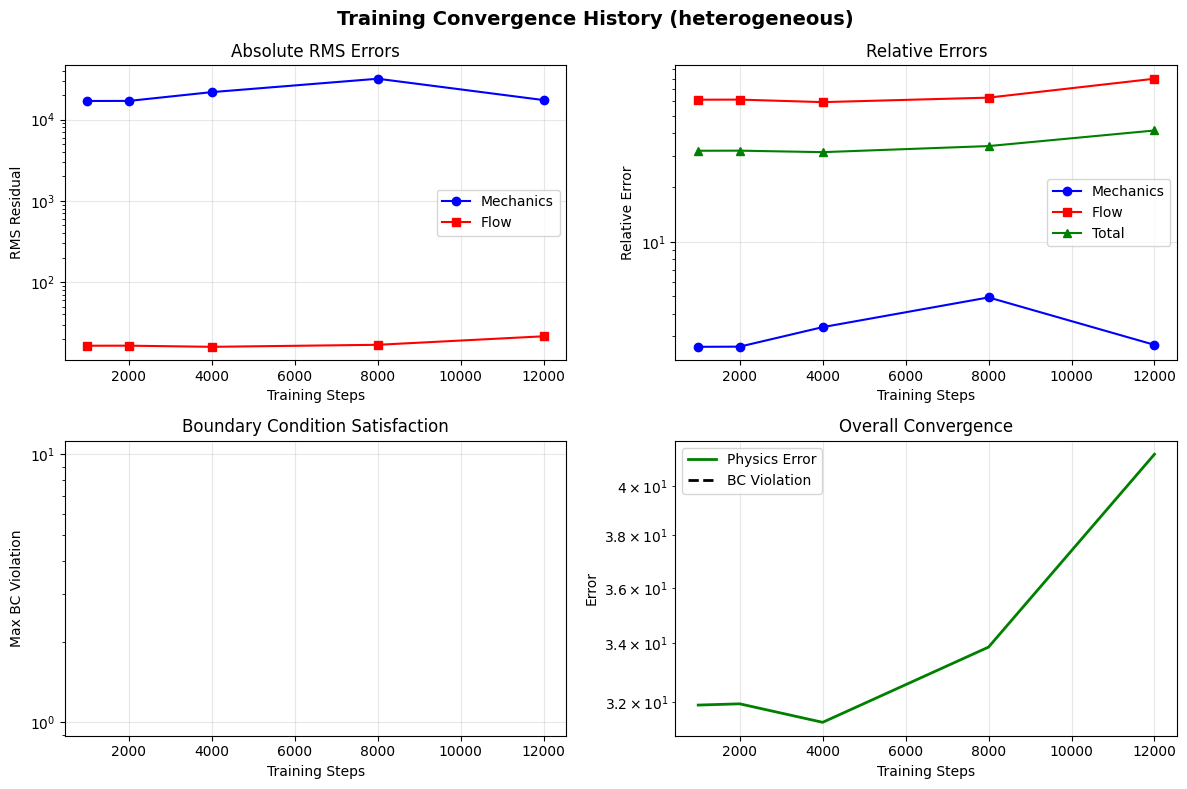

In [4]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.7"  # Leave some memory

import jax.numpy as jnp
from jax import config as jax_config
jax_config.update('jax_default_matmul_precision', 'tensorfloat32')

from poroelasticity.trainers.coupled_model import FixedTrainer

# Create trainer
trainer = FixedTrainer()

# Use moderate sampling that won't OOM
trainer.config.ns = ((30, 30, 8), (0,), (0,), (0,), (0,))  # 7,200 points
trainer.config.sampler = "sobol"  # Better coverage
trainer.trainer.c.sampler = "sobol"
trainer.trainer.c.ns = trainer.config.ns

# Rebuild trainer
from fbpinns.trainers import FBPINNTrainer
trainer.trainer = FBPINNTrainer(trainer.config)

# Train with slightly more steps to compensate
history = trainer.track_convergence_history(
    checkpoint_steps=[1000, 2000, 4000, 8000, 12000],
    save_checkpoints=True,
    checkpoint_dir="checkpoints_inverse_adaptive"
)


CHECKPOINT EVALUATION - Finding Best Model

Found 5 checkpoints to evaluate...
------------------------------------------------------------

Evaluating checkpoint at step 1000...
  Mechanics Rel: 2.617e+00, Flow Rel: 6.119e+01, Total: 3.191e+01

Evaluating checkpoint at step 2000...
  Mechanics Rel: 2.623e+00, Flow Rel: 6.127e+01, Total: 3.195e+01

Evaluating checkpoint at step 4000...
  Mechanics Rel: 3.364e+00, Flow Rel: 5.932e+01, Total: 3.134e+01

Evaluating checkpoint at step 8000...
  Mechanics Rel: 4.914e+00, Flow Rel: 6.283e+01, Total: 3.387e+01

Evaluating checkpoint at step 12000...
  Mechanics Rel: 2.683e+00, Flow Rel: 7.995e+01, Total: 4.132e+01

BEST CHECKPOINTS BY DIFFERENT CRITERIA

1. BEST TOTAL RELATIVE ERROR:
   Step 4000: Total=3.134e+01 (Mech=3.364e+00, Flow=5.932e+01)
   File: model_step_4000.pkl

2. BEST FLOW ERROR:
   Step 4000: Flow=5.932e+01 (Mech=3.364e+00, Total=3.134e+01)
   File: model_step_4000.pkl

3. BEST BALANCED (min of max):
   Step 4000: Max=5.932e+

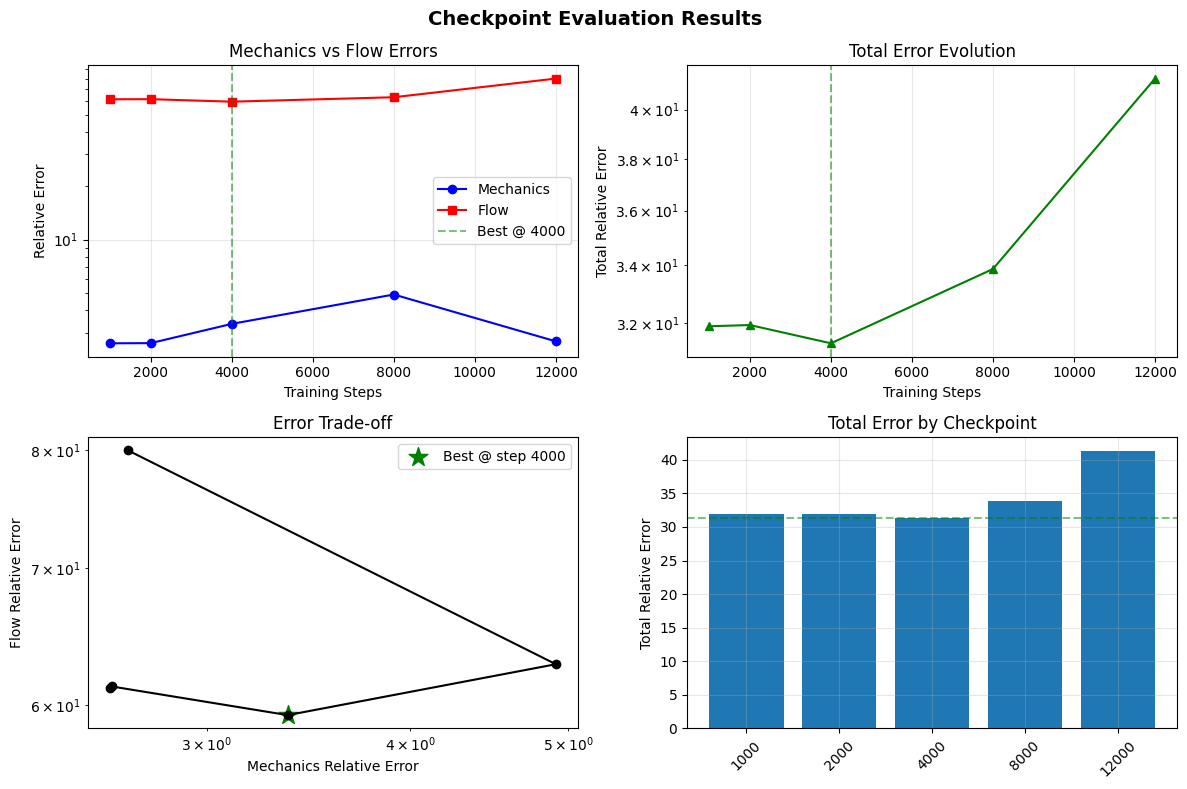


LOADING BEST CHECKPOINT
 Loaded best checkpoint from step 4000
   Total Error: 3.134e+01
   Mechanics: 3.364e+00, Flow: 5.932e+01


In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def evaluate_all_checkpoints(trainer, checkpoint_dir="checkpoints_inverse_adaptive", n_points=20):
    """
    Evaluate all checkpoints in a directory and find the best one.
    """
    print("\n" + "="*60)
    print("CHECKPOINT EVALUATION - Finding Best Model")
    print("="*60)

    # Get all checkpoint files
    if not os.path.exists(checkpoint_dir):
        print(f"Directory {checkpoint_dir} not found!")
        return None

    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pkl')]
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Sort by step number

    if not checkpoint_files:
        print("No checkpoint files found!")
        return None

    results = []

    print(f"\nFound {len(checkpoint_files)} checkpoints to evaluate...")
    print("-" * 60)

    for checkpoint_file in checkpoint_files:
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        step_num = int(checkpoint_file.split('_')[-1].split('.')[0])

        print(f"\nEvaluating checkpoint at step {step_num}...")

        try:
            # Load checkpoint
            with open(checkpoint_path, 'rb') as f:
                checkpoint = pickle.load(f)

            # Update trainer with checkpoint
            trainer.all_params = checkpoint['all_params']

            # Compute physics metrics
            metrics = trainer.compute_physics_metrics(n_points=n_points, method='fd_xy_ad_t')

            # Verify BCs
            import io
            import sys
            old_stdout = sys.stdout
            sys.stdout = io.StringIO()
            bc_satisfied = trainer.verify_bcs(n_points=20, t=1.0)
            sys.stdout = old_stdout

            # Store results
            result = {
                'step': step_num,
                'file': checkpoint_file,
                'path': checkpoint_path,
                'mechanics_rms': metrics['mechanics_rms'],
                'flow_rms': metrics['flow_rms'],
                'mechanics_rel': metrics['mechanics_rel'],
                'flow_rel': metrics['flow_rel'],
                'total_rel': metrics['total_rel'],
                'bc_satisfied': bc_satisfied,
                'status': metrics['status']
            }
            results.append(result)

            print(f"  Mechanics Rel: {metrics['mechanics_rel']:.3e}, Flow Rel: {metrics['flow_rel']:.3e}, Total: {metrics['total_rel']:.3e}")

        except Exception as e:
            print(f"  ERROR loading checkpoint: {e}")
            continue

    if not results:
        print("No valid checkpoints found")
        return None

    # Find best checkpoints by different criteria
    print("\n" + "="*60)
    print("BEST CHECKPOINTS BY DIFFERENT CRITERIA")
    print("="*60)

    # Best by total relative error
    best_total = min(results, key=lambda x: x['total_rel'])
    print(f"\n1. BEST TOTAL RELATIVE ERROR:")
    print(f"   Step {best_total['step']}: Total={best_total['total_rel']:.3e} (Mech={best_total['mechanics_rel']:.3e}, Flow={best_total['flow_rel']:.3e})")
    print(f"   File: {best_total['file']}")

    # Best by flow
    best_flow = min(results, key=lambda x: x['flow_rel'])
    print(f"\n2. BEST FLOW ERROR:")
    print(f"   Step {best_flow['step']}: Flow={best_flow['flow_rel']:.3e} (Mech={best_flow['mechanics_rel']:.3e}, Total={best_flow['total_rel']:.3e})")
    print(f"   File: {best_flow['file']}")

    # Best balanced (minimum of max between mechanics and flow)
    best_balanced = min(results, key=lambda x: max(x['mechanics_rel'], x['flow_rel']))
    print(f"\n3. BEST BALANCED (min of max):")
    print(f"   Step {best_balanced['step']}: Max={max(best_balanced['mechanics_rel'], best_balanced['flow_rel']):.3e} (Mech={best_balanced['mechanics_rel']:.3e}, Flow={best_balanced['flow_rel']:.3e})")
    print(f"   File: {best_balanced['file']}")

    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    steps = [r['step'] for r in results]
    mech_rels = [r['mechanics_rel'] for r in results]
    flow_rels = [r['flow_rel'] for r in results]
    total_rels = [r['total_rel'] for r in results]

    # Mechanics vs Flow
    axes[0, 0].semilogy(steps, mech_rels, 'b-o', label='Mechanics')
    axes[0, 0].semilogy(steps, flow_rels, 'r-s', label='Flow')
    axes[0, 0].axvline(best_total['step'], color='g', linestyle='--', alpha=0.5, label=f"Best @ {best_total['step']}")
    axes[0, 0].set_xlabel('Training Steps')
    axes[0, 0].set_ylabel('Relative Error')
    axes[0, 0].set_title('Mechanics vs Flow Errors')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Total error
    axes[0, 1].semilogy(steps, total_rels, 'g-^')
    axes[0, 1].axvline(best_total['step'], color='g', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Training Steps')
    axes[0, 1].set_ylabel('Total Relative Error')
    axes[0, 1].set_title('Total Error Evolution')
    axes[0, 1].grid(True, alpha=0.3)

    # Scatter: Mechanics vs Flow
    axes[1, 0].loglog(mech_rels, flow_rels, 'ko-')
    axes[1, 0].scatter([best_total['mechanics_rel']], [best_total['flow_rel']],
                       color='g', s=200, marker='*', label=f"Best @ step {best_total['step']}")
    axes[1, 0].set_xlabel('Mechanics Relative Error')
    axes[1, 0].set_ylabel('Flow Relative Error')
    axes[1, 0].set_title('Error Trade-off')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Bar chart of all steps
    axes[1, 1].bar(range(len(results)), [r['total_rel'] for r in results])
    axes[1, 1].set_xticks(range(len(results)))
    axes[1, 1].set_xticklabels([r['step'] for r in results], rotation=45)
    axes[1, 1].set_ylabel('Total Relative Error')
    axes[1, 1].set_title('Total Error by Checkpoint')
    axes[1, 1].axhline(y=best_total['total_rel'], color='g', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Checkpoint Evaluation Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return results, best_total, best_flow, best_balanced

# Run the evaluation
results, best_total, best_flow, best_balanced = evaluate_all_checkpoints(trainer)

# Load the best checkpoint
if best_total:
    print("\n" + "="*60)
    print("LOADING BEST CHECKPOINT")
    print("="*60)

    best_checkpoint_path = best_total['path']
    with open(best_checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)

    trainer.all_params = checkpoint['all_params']
    print(f" Loaded best checkpoint from step {best_total['step']}")
    print(f"   Total Error: {best_total['total_rel']:.3e}")
    print(f"   Mechanics: {best_total['mechanics_rel']:.3e}, Flow: {best_total['flow_rel']:.3e}")

In [8]:
import pickle

# Load the best checkpoint (step 4000 had the best results)
checkpoint_path = 'checkpoints_inverse_adaptive/model_step_4000.pkl'

# Load the checkpoint
with open(checkpoint_path, 'rb') as f:
    checkpoint = pickle.load(f)

# Update the trainer with the loaded parameters
trainer.all_params = checkpoint['all_params']

print(f"Loaded checkpoint from: {checkpoint_path}")

# Detailed physics metrics
print("\n" + "="*60)
print("Detailed Physics Validation")
print("="*60)

metrics = trainer.compute_physics_metrics(n_points=30, method='fd_xy_ad_t')
print(f"\nFinal Results with Fixed Weight=20 (Step 4000):")
print(f"  Mechanics RMS: {metrics['mechanics_rms']:.2e}")
print(f"  Flow RMS: {metrics['flow_rms']:.2e}")
print(f"  Mechanics Relative: {metrics['mechanics_rel']:.2e}")
print(f"  Flow Relative: {metrics['flow_rel']:.2e}")
print(f"  Total Relative: {metrics['total_rel']:.2e}")
print(f"  Status: {metrics['status']}")

# Verify boundary conditions
trainer.verify_bcs(t=1.0)

# Plot solution fields
#trainer.plot_solution(n_points=100, t=1.0)

# Test at specific points to show the heterogeneity effect
print("\n Point Values at t=1.0:")
test_points = [
    [0.5, 0.15],  # In reservoir (high k=10)
    [0.5, 0.30],  # At interface
    [0.5, 0.45],  # In caprock (low k=0.1)
]
x_points = jnp.array(test_points)
pred = trainer.predict(x_points, t=1.0)

print("  Location         | ux      | uy      | p")
print("  -----------------|---------|---------|--------")
print(f"  Reservoir (y=0.15)| {pred[0,0]:7.4f} | {pred[0,1]:7.4f} | {pred[0,2]:7.4f}")
print(f"  Interface (y=0.30)| {pred[1,0]:7.4f} | {pred[1,1]:7.4f} | {pred[1,2]:7.4f}")
print(f"  Caprock   (y=0.45)| {pred[2,0]:7.4f} | {pred[2,1]:7.4f} | {pred[2,2]:7.4f}")

Loaded checkpoint from: checkpoints_inverse_adaptive/model_step_4000.pkl

Detailed Physics Validation

Final Results with Fixed Weight=20 (Step 4000):
  Mechanics RMS: 2.41e+04
  Flow RMS: 1.52e+01
  Mechanics Relative: 3.71e+00
  Flow Relative: 5.70e+01
  Total Relative: 3.04e+01
  Status: NEEDS IMPROVEMENT

Boundary Condition Verification at t=1.0
Left boundary (x=0): ux=0, uy=0, p=pL(y,t)
  max|ux| = 0.00e+00
  max|uy| = 0.00e+00
  max|p - pL| = 0.00e+00
Right boundary (x=1): p=0
  max|p| = 0.00e+00
Bottom boundary (y=0): uy=0
  max|uy| = 0.00e+00

Status: PERFECT - All BCs satisfied to machine precision

 Point Values at t=1.0:
  Location         | ux      | uy      | p
  -----------------|---------|---------|--------
  Reservoir (y=0.15)|  0.3132 | -0.0072 |  0.0799
  Interface (y=0.30)|  0.4164 |  0.0542 |  0.0859
  Caprock   (y=0.45)|  0.2476 |  0.0932 |  0.0844



SOLUTION FIELDS AT t=1.0

Field Statistics:
  Pressure:     min=0.0000, max=0.9931, mean=0.0851
  u_x:          min=-0.4762, max=0.4268, mean=0.0972
  u_y:          min=-0.0505, max=0.2060, mean=0.0576
  |u|:          min=0.0000, max=0.5188, mean=0.2109

Material Property Ranges:
  Permeability: min=0.10, max=10.00
  Young's Mod:  min=5000.0, max=7000.0


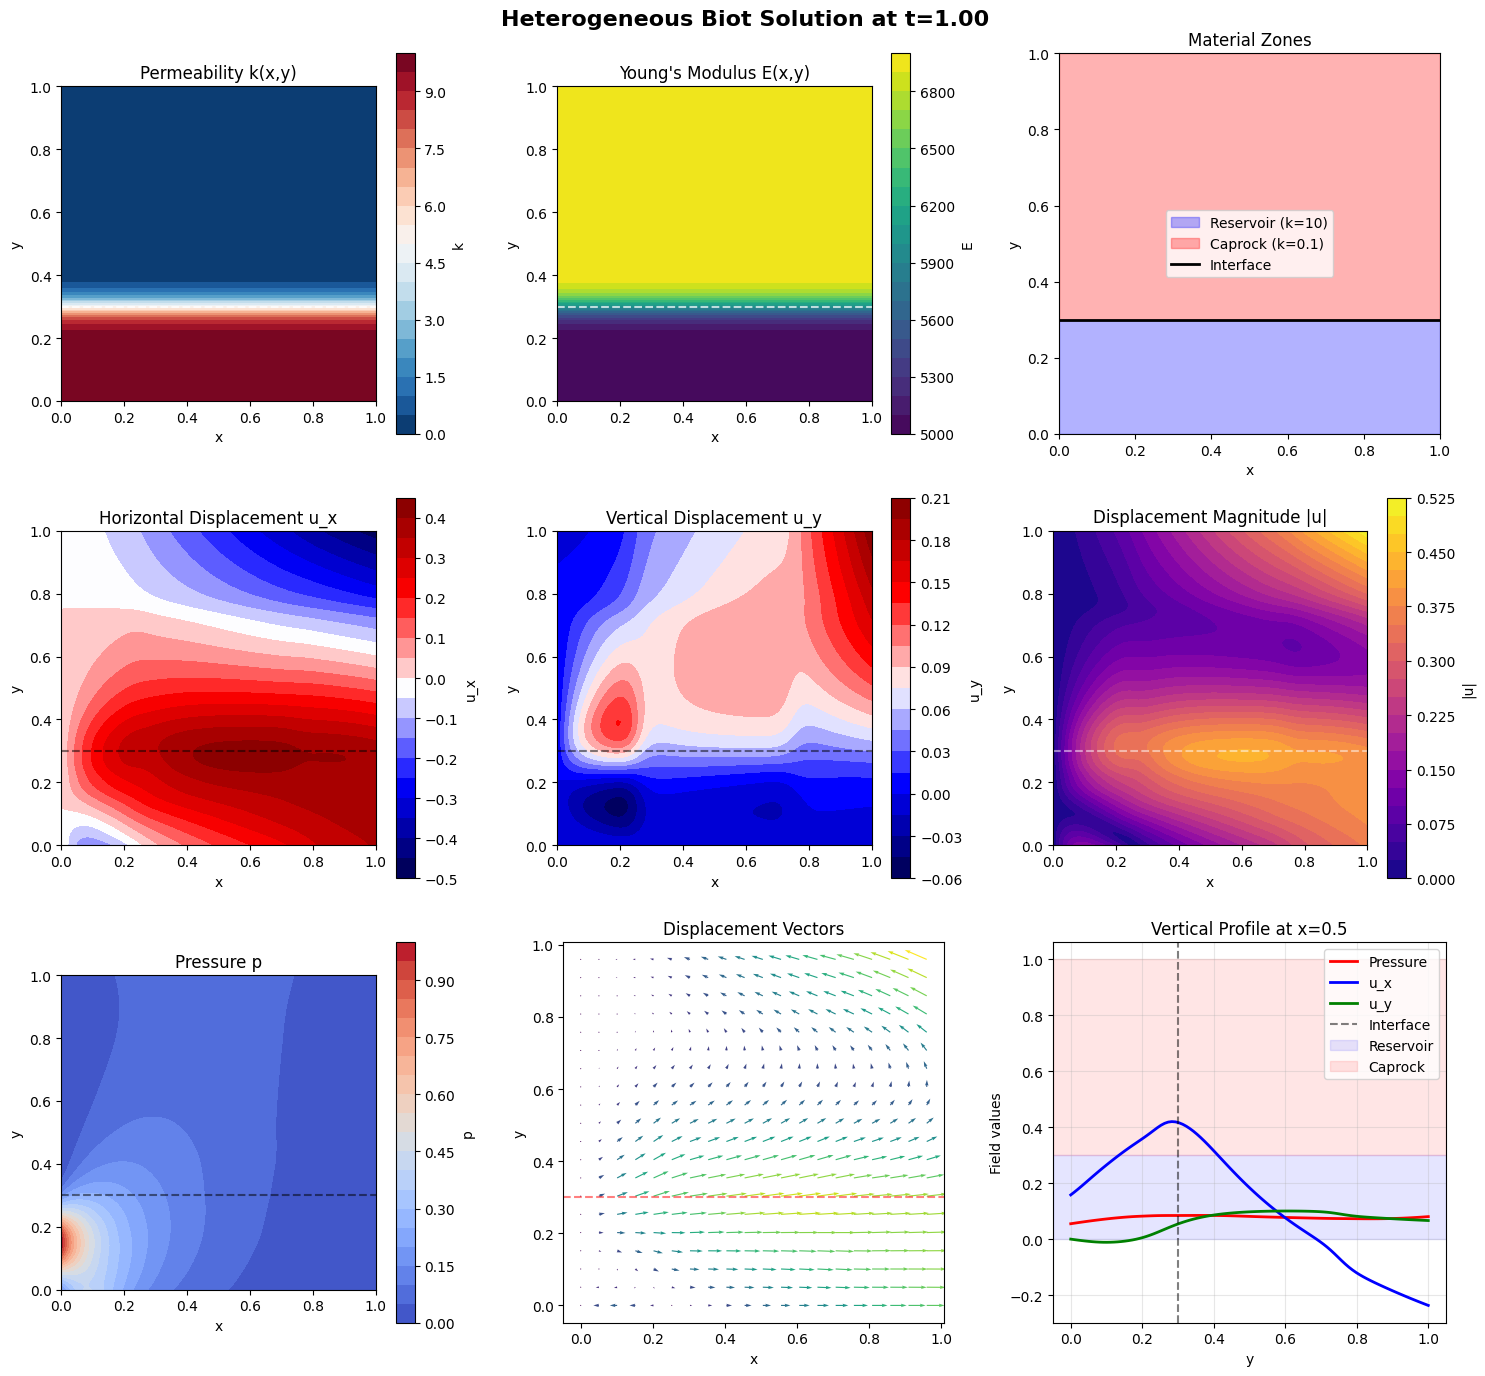

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from matplotlib.patches import Rectangle

def plot_solution(trainer, n_points=100, t=1.0, save_path=None):
    """
    Comprehensive visualization of the heterogeneous Biot solution.

    Args:
        trainer: Your trained BiotCoupledTrainer_Heterogeneous instance
        n_points: Resolution for the plots
        t: Time snapshot to visualize
        save_path: Optional path to save the figure
    """
    print("\n" + "="*60)
    print(f"SOLUTION FIELDS AT t={t}")
    print("="*60)

    # Create evaluation grid
    x = jnp.linspace(0, 1, n_points)
    y = jnp.linspace(0, 1, n_points)
    X, Y = jnp.meshgrid(x, y)
    T = jnp.full((n_points * n_points,), t)

    # Create input points
    points = jnp.column_stack([X.flatten(), Y.flatten(), T])

    # Get predictions
    pred = trainer.predict(points, t=t)

    # Reshape predictions
    ux = pred[:, 0].reshape(n_points, n_points)
    uy = pred[:, 1].reshape(n_points, n_points)
    p = pred[:, 2].reshape(n_points, n_points)

    # Calculate displacement magnitude
    u_mag = jnp.sqrt(ux**2 + uy**2)

    # Get material properties for visualization
    prob = trainer.all_params["static"]["problem"]
    k_fun = prob.get("k_fun", BiotCoupled2D_Heterogeneous.default_k_fun)
    E_fun = prob.get("E_fun", BiotCoupled2D_Heterogeneous.default_E_fun)

    # Evaluate material properties on grid
    k_field = k_fun(X.flatten(), Y.flatten()).reshape(n_points, n_points)
    E_field = E_fun(X.flatten(), Y.flatten()).reshape(n_points, n_points)

    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 14))

    # Row 1: Material Properties
    # Permeability field
    im1 = axes[0, 0].contourf(X, Y, k_field, levels=20, cmap='RdBu_r')
    axes[0, 0].axhline(y=0.3, color='white', linestyle='--', alpha=0.7, label='Interface')
    axes[0, 0].set_title('Permeability k(x,y)')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 0], label='k')
    axes[0, 0].set_aspect('equal')

    # Young's modulus field
    im2 = axes[0, 1].contourf(X, Y, E_field, levels=20, cmap='viridis')
    axes[0, 1].axhline(y=0.3, color='white', linestyle='--', alpha=0.7, label='Interface')
    axes[0, 1].set_title("Young's Modulus E(x,y)")
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[0, 1], label='E')
    axes[0, 1].set_aspect('equal')

    # Material zones visualization
    axes[0, 2].fill_between([0, 1], [0, 0], [0.3, 0.3],
                            color='blue', alpha=0.3, label='Reservoir (k=10)')
    axes[0, 2].fill_between([0, 1], [0.3, 0.3], [1, 1],
                            color='red', alpha=0.3, label='Caprock (k=0.1)')
    axes[0, 2].axhline(y=0.3, color='black', linestyle='-', linewidth=2, label='Interface')
    axes[0, 2].set_xlim(0, 1)
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].set_title('Material Zones')
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')
    axes[0, 2].legend(loc='center')
    axes[0, 2].set_aspect('equal')

    # Row 2: Displacement Fields
    # ux field
    im3 = axes[1, 0].contourf(X, Y, ux, levels=20, cmap='seismic')
    axes[1, 0].axhline(y=0.3, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_title(f'Horizontal Displacement u_x')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im3, ax=axes[1, 0], label='u_x')
    axes[1, 0].set_aspect('equal')

    # uy field
    im4 = axes[1, 1].contourf(X, Y, uy, levels=20, cmap='seismic')
    axes[1, 1].axhline(y=0.3, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title(f'Vertical Displacement u_y')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    plt.colorbar(im4, ax=axes[1, 1], label='u_y')
    axes[1, 1].set_aspect('equal')

    # Displacement magnitude
    im5 = axes[1, 2].contourf(X, Y, u_mag, levels=20, cmap='plasma')
    axes[1, 2].axhline(y=0.3, color='white', linestyle='--', alpha=0.5)
    axes[1, 2].set_title(f'Displacement Magnitude |u|')
    axes[1, 2].set_xlabel('x')
    axes[1, 2].set_ylabel('y')
    plt.colorbar(im5, ax=axes[1, 2], label='|u|')
    axes[1, 2].set_aspect('equal')

    # Row 3: Pressure and Analysis
    # Pressure field
    im6 = axes[2, 0].contourf(X, Y, p, levels=20, cmap='coolwarm')
    axes[2, 0].axhline(y=0.3, color='black', linestyle='--', alpha=0.5)
    axes[2, 0].set_title(f'Pressure p')
    axes[2, 0].set_xlabel('x')
    axes[2, 0].set_ylabel('y')
    plt.colorbar(im6, ax=axes[2, 0], label='p')
    axes[2, 0].set_aspect('equal')

    # Displacement vectors (quiver plot)
    skip = n_points // 20  # Reduce density for clarity
    axes[2, 1].quiver(X[::skip, ::skip], Y[::skip, ::skip],
                      ux[::skip, ::skip], uy[::skip, ::skip],
                      u_mag[::skip, ::skip], cmap='viridis')
    axes[2, 1].axhline(y=0.3, color='red', linestyle='--', alpha=0.5)
    axes[2, 1].set_title('Displacement Vectors')
    axes[2, 1].set_xlabel('x')
    axes[2, 1].set_ylabel('y')
    axes[2, 1].set_aspect('equal')

    # Line plots at x=0.5
    x_idx = n_points // 2
    axes[2, 2].plot(y, p[:, x_idx], 'r-', label='Pressure', linewidth=2)
    axes[2, 2].plot(y, ux[:, x_idx], 'b-', label='u_x', linewidth=2)
    axes[2, 2].plot(y, uy[:, x_idx], 'g-', label='u_y', linewidth=2)
    axes[2, 2].axvline(x=0.3, color='black', linestyle='--', alpha=0.5, label='Interface')
    axes[2, 2].axhspan(0, 0.3, alpha=0.1, color='blue', label='Reservoir')
    axes[2, 2].axhspan(0.3, 1.0, alpha=0.1, color='red', label='Caprock')
    axes[2, 2].set_xlabel('y')
    axes[2, 2].set_ylabel('Field values')
    axes[2, 2].set_title('Vertical Profile at x=0.5')
    axes[2, 2].legend()
    axes[2, 2].grid(True, alpha=0.3)

    plt.suptitle(f'Heterogeneous Biot Solution at t={t:.2f}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Print field statistics
    print(f"\nField Statistics:")
    print(f"  Pressure:     min={float(jnp.min(p)):.4f}, max={float(jnp.max(p)):.4f}, mean={float(jnp.mean(p)):.4f}")
    print(f"  u_x:          min={float(jnp.min(ux)):.4f}, max={float(jnp.max(ux)):.4f}, mean={float(jnp.mean(ux)):.4f}")
    print(f"  u_y:          min={float(jnp.min(uy)):.4f}, max={float(jnp.max(uy)):.4f}, mean={float(jnp.mean(uy)):.4f}")
    print(f"  |u|:          min={float(jnp.min(u_mag)):.4f}, max={float(jnp.max(u_mag)):.4f}, mean={float(jnp.mean(u_mag)):.4f}")

    print(f"\nMaterial Property Ranges:")
    print(f"  Permeability: min={float(jnp.min(k_field)):.2f}, max={float(jnp.max(k_field)):.2f}")
    print(f"  Young's Mod:  min={float(jnp.min(E_field)):.1f}, max={float(jnp.max(E_field)):.1f}")

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")

    plt.show()

    return fig, axes

# Call the function
fig, axes = plot_solution(trainer, n_points=100, t=1.0)

In [13]:
# Detailed physics metrics
print("\n" + "="*60)
print("DETAILED PHYSICS VALIDATION")
print("="*60)

metrics = trainer.compute_physics_metrics(n_points=30, method='fd_xy_ad_t')
print(f"\nFinal Results with Fixed Weighting:")
print(f"  Mechanics RMS: {metrics['mechanics_rms']:.2e}")
print(f"  Flow RMS: {metrics['flow_rms']:.2e}")
print(f"  Mechanics Relative: {metrics['mechanics_rel']:.2e}")
print(f"  Flow Relative: {metrics['flow_rel']:.2e}")
print(f"  Total Relative: {metrics['total_rel']:.2e}")
print(f"  Status: {metrics['status']}")

# Verify boundary conditions
trainer.verify_bcs(t=1.0)

# Plot solution fields
#trainer.plot_solution(n_points=50, t=1.0)

# Test at specific points
T_SNAPSHOT = 1.0
x_points = jnp.array([[0.0, 0.5], [1.0, 0.5], [0.5, 0.0], [0.5, 0.5]])
pred = trainer.predict(x_points, t=T_SNAPSHOT)
print("\nTest Points at t=1.0:")
print(f"  (0.0, 0.5): ux={pred[0,0]:.4f}, uy={pred[0,1]:.4f}, p={pred[0,2]:.4f}")
print(f"  (1.0, 0.5): ux={pred[1,0]:.4f}, uy={pred[1,1]:.4f}, p={pred[1,2]:.4f}")
print(f"  (0.5, 0.0): ux={pred[2,0]:.4f}, uy={pred[2,1]:.4f}, p={pred[2,2]:.4f}")
print(f"  (0.5, 0.5): ux={pred[3,0]:.4f}, uy={pred[3,1]:.4f}, p={pred[3,2]:.4f}")


DETAILED PHYSICS VALIDATION

Final Results with Fixed Weighting:
  Mechanics RMS: 2.41e+04
  Flow RMS: 1.52e+01
  Mechanics Relative: 3.71e+00
  Flow Relative: 5.70e+01
  Total Relative: 3.04e+01
  Status: NEEDS IMPROVEMENT

Boundary Condition Verification at t=1.0
Left boundary (x=0): ux=0, uy=0, p=pL(y,t)
  max|ux| = 0.00e+00
  max|uy| = 0.00e+00
  max|p - pL| = 0.00e+00
Right boundary (x=1): p=0
  max|p| = 0.00e+00
Bottom boundary (y=0): uy=0
  max|uy| = 0.00e+00

Status: PERFECT - All BCs satisfied to machine precision

Test Points at t=1.0:
  (0.0, 0.5): ux=0.0000, uy=0.0000, p=0.0001
  (1.0, 0.5): ux=0.1330, uy=0.1169, p=0.0000
  (0.5, 0.0): ux=0.1558, uy=-0.0000, p=0.0561
  (0.5, 0.5): ux=0.1839, uy=0.0974, p=0.0821


t=0.25: Mech=3.27e-01, Flow=4.28e+01
t=0.5: Mech=6.04e-01, Flow=5.74e+01
t=0.75: Mech=1.44e+00, Flow=6.11e+01
t=1.0: Mech=3.36e+00, Flow=6.02e+01


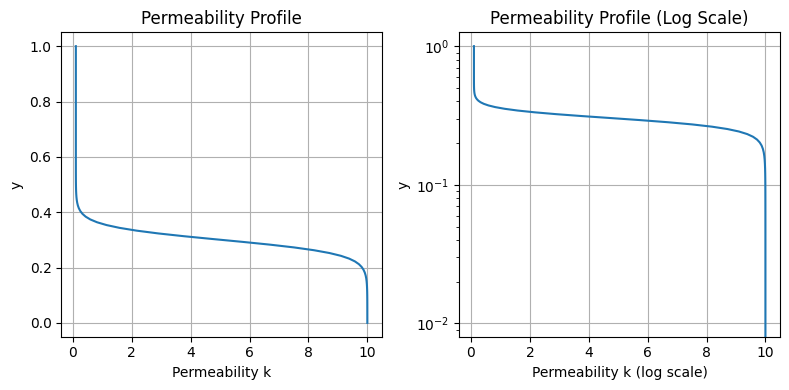

In [14]:
# If you added the visualize_residual_maps method
#if hasattr(trainer, 'visualize_residual_maps'):
#    trainer.visualize_residual_maps(t=1.0)

# Check convergence at different times
for t in [0.25, 0.5, 0.75, 1.0]:
    metrics_t = trainer.compute_physics_metrics(n_points=20, method='steady_fd', t=t)
    print(f"t={t}: Mech={metrics_t['mechanics_rel']:.2e}, Flow={metrics_t['flow_rel']:.2e}")

# Visualize permeability distribution
import matplotlib.pyplot as plt
y_test = jnp.linspace(0, 1, 100)
x_test = jnp.ones_like(y_test) * 0.5
k_values = trainer.config.problem.default_k_fun(x_test, y_test)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, y_test)
plt.xlabel('Permeability k')
plt.ylabel('y')
plt.title('Permeability Profile')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.semilogy(k_values, y_test)
plt.xlabel('Permeability k (log scale)')
plt.ylabel('y')
plt.title('Permeability Profile (Log Scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Save checkpoints
import shutil
shutil.copytree('checkpoints_inverse_adaptive',
                '/content/drive/MyDrive/biot_checkpoints_inverse')

# Save the history dictionary
import pickle
with open('/content/drive/MyDrive/biot_history_inverse.pkl', 'wb') as f:
    pickle.dump(history, f)

# Save the final metrics
with open('/content/drive/MyDrive/biot_metrics_inverse.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print(" Saved to Google Drive:")
print("  - Checkpoints: /MyDrive/biot_checkpoints_inverse/")
print("  - History: /MyDrive/biot_history_inverse.pkl")
print("  - Metrics: /MyDrive/biot_metrics_inverse.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Saved to Google Drive:
  - Checkpoints: /MyDrive/biot_checkpoints_inverse/
  - History: /MyDrive/biot_history_inverse.pkl
  - Metrics: /MyDrive/biot_metrics_inverse.pkl
